## Model Selection for dataset with food

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

script_path = os.path.realpath(os.path.dirname(__name__))
os.chdir(script_path)
sys.path.append("/workspace/collab-environment/")
sys.path.append("/workspace/collab-environment/collab_env/gnn")
sys.path.append("/workspace/collab-environment/collab_env/data/boids")

In [3]:
from itertools import combinations
from typing import Any

import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn.functional as functional
from torch.utils.data import random_split
from torch_geometric.data import DataLoader

from collab_env.data.file_utils import expand_path, get_project_root

In [4]:
from collab_env.gnn.gnn import get_adjcency_from_debug, plot_log_loss, train_rules_gnn, load_model, save_model, debug_result2prediction
from collab_env.gnn.gnn_definition import GNN, Lazy
from collab_env.data.boids.animal_simulation import visualize_graph_2sets, static_visualize_2sets

from collab_env.gnn.utility import dataset2testloader
from collab_env.gnn.plotting_utility import load_various_data, load_rollout
from itertools import product

In [5]:
torch.cuda.empty_cache()

In [6]:
data_names = ['boid_food_basic','boid_food_independent','boid_food_strong'] #'runpod/boid_single_species_basic']

data_names_short = {}
data_names_short['boid_single_species_independent'] = 'idpnt'
data_names_short['boid_single_species_basic'] = 'boid'
data_names_short['boid_food_basic'] = 'foodbasic'
data_names_short['boid_food_independent'] = 'foodidpnt'
data_names_short['boid_food_strong'] = 'foodstrong'

              #'boid_single_species_weak_alignment',
              #'boid_single_species_strong_alignment']#, 'boid_single_species_independent', # without food
              #'boid_food_basic_alignment', 'boid_food_basic_independent', # with food
              #'boid_food_strong'] # with food, strong influence

model_names = ["vpluspplus_a"]
noise_levels = [0, 0.005]
heads = [1,2,3]
visual_ranges = [0.1, 0.5]
seeds = [0,1,2,3,4]

all_combinations = list(product(data_names, model_names, noise_levels, heads, visual_ranges, seeds))


In [7]:
rollout_results =  {}
data = {}
model_names = {}
for ind in range(len(all_combinations)):

    data_name, model_name, n, h, vr, s = all_combinations[ind]

    spec = {
        "data_name": data_name,
        "head": h,
        "visual_range": vr,
        "seed": s,
        "rollout_starting_frame": 5,
        "noise": n,
        "seed": s,
        "old_format": False
    }
    
    data_name_short = data_names_short[data_name]
    model_save_name = f'{data_name_short}_\nn{n}_h{h}_vr{vr}_s{s}'

    try:
        
        rollout_results[ind] = load_rollout(
            "vpluspplus_a", **spec)
        model_names[ind] = model_save_name
        print(f"Successfully import {model_save_name}")
    except:
        print(f"Cannot import {model_save_name}")


Cannot import foodbasic_
n0_h1_vr0.1_s0
Cannot import foodbasic_
n0_h1_vr0.1_s1
Cannot import foodbasic_
n0_h1_vr0.1_s2
Cannot import foodbasic_
n0_h1_vr0.1_s3
Cannot import foodbasic_
n0_h1_vr0.1_s4
Successfully import foodbasic_
n0_h1_vr0.5_s0
Successfully import foodbasic_
n0_h1_vr0.5_s1
Successfully import foodbasic_
n0_h1_vr0.5_s2
Successfully import foodbasic_
n0_h1_vr0.5_s3
Successfully import foodbasic_
n0_h1_vr0.5_s4
Cannot import foodbasic_
n0_h2_vr0.1_s0
Cannot import foodbasic_
n0_h2_vr0.1_s1
Cannot import foodbasic_
n0_h2_vr0.1_s2
Cannot import foodbasic_
n0_h2_vr0.1_s3
Cannot import foodbasic_
n0_h2_vr0.1_s4
Successfully import foodbasic_
n0_h2_vr0.5_s0
Successfully import foodbasic_
n0_h2_vr0.5_s1
Successfully import foodbasic_
n0_h2_vr0.5_s2
Successfully import foodbasic_
n0_h2_vr0.5_s3
Successfully import foodbasic_
n0_h2_vr0.5_s4
Cannot import foodbasic_
n0_h3_vr0.1_s0
Cannot import foodbasic_
n0_h3_vr0.1_s1
Cannot import foodbasic_
n0_h3_vr0.1_s2
Cannot import foodba

In [34]:
def sqr_diff_np(pred, actual):
    return np.mean(np.sqrt(np.sum((pred - actual) ** 2, axis = 2))[:,:20], axis = 1)

In [35]:
def return_mse(rollout_result, starting_frame, end_frame):
    
    F = len(rollout_result[0]['predicted']) #frames
    mse_by_frame = []
    std_by_frame = []
    for f in range(starting_frame, end_frame):
        Sqrdiff = []
        for b in rollout_result:
            pred = rollout_result[b]['predicted'][f]
            actual = rollout_result[b]['actual'][f]
            Sqrdiff.append(sqr_diff_np(pred, actual))

        mse_by_frame.append(np.mean(np.concatenate(Sqrdiff, axis = 0)))
        std_by_frame.append(np.std(np.concatenate(Sqrdiff, axis = 0)))
    return np.array(mse_by_frame), np.array(std_by_frame)

Text(0.5, 1.0, 'Independent dataset')

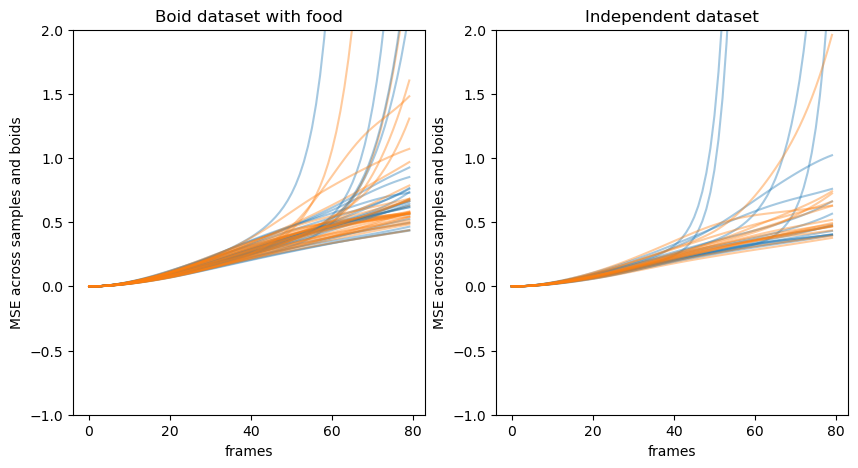

In [44]:
starting_frame = 0
end_frame = 80

mse_by_frame_all = []
mse_by_frame_all_dict = {} #fool-proof
std_by_frame_all = []
std_by_frame_all_dict = {}

fig, axes = plt.subplots(nrows=1, ncols=2,
                         figsize=(10, 5))

for m in rollout_results:
    if "idpnt" in model_names[m]:
        ax = axes[1]
    else:
        ax = axes[0]
        
    
    mse_by_frame, std_by_frame = return_mse(rollout_results[m][0], starting_frame, end_frame)
    if mse_by_frame[60] <= 0.5:
        label = model_names[m]
    else:
        label = None

    if "n0.005" in model_names[m]:
        c = 'C1'
    else:
        c = 'C0'

    # tally
    mse_by_frame_all.append(mse_by_frame)
    mse_by_frame_all_dict[m] = np.sum(mse_by_frame)

    std_by_frame_all.append(std_by_frame)
    std_by_frame_all_dict[m] = np.sum(std_by_frame)
        
    ax.plot(mse_by_frame, label = label, color = c, alpha = 0.4)
    #ax.fill_between(np.arange(len(mse_by_frame)), mse_by_frame - std_by_frame, mse_by_frame + std_by_frame, alpha = 0.2)

for ax in axes:
    ax.set_ylim([-1,2])
    ax.set_xlabel('frames')
    ax.set_ylabel('MSE across samples and boids')

#axes[0].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
#axes[1].legend(bbox_to_anchor=(0, -0.8), loc='lower left')
axes[0].set_title("Boid dataset with food")
axes[1].set_title("Independent dataset")

### Does noise help rollout?

In [12]:
import pandas as pd
import seaborn as sns

In [39]:
mse_noise_idpnt, mse_nonoise_idpnt = [], []
mse_noise_boid, mse_nonoise_boid = [], []

for m in rollout_results:
    mse_ = np.log(mse_by_frame_all_dict[m])
    
    if "n0.005" in model_names[m]:
        if "basic" in model_names[m]:
            mse_noise_boid.append(mse_)
        elif "idpnt" in model_names[m]:
            mse_noise_idpnt.append(mse_)
    else:
        if "basic" in model_names[m]:
            mse_nonoise_boid.append(mse_)
        elif "idpnt" in model_names[m]:
            mse_nonoise_idpnt.append(mse_)

/tmp/ipykernel_25586/562766763.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Group', y='Value', data=df, palette=my_pal)


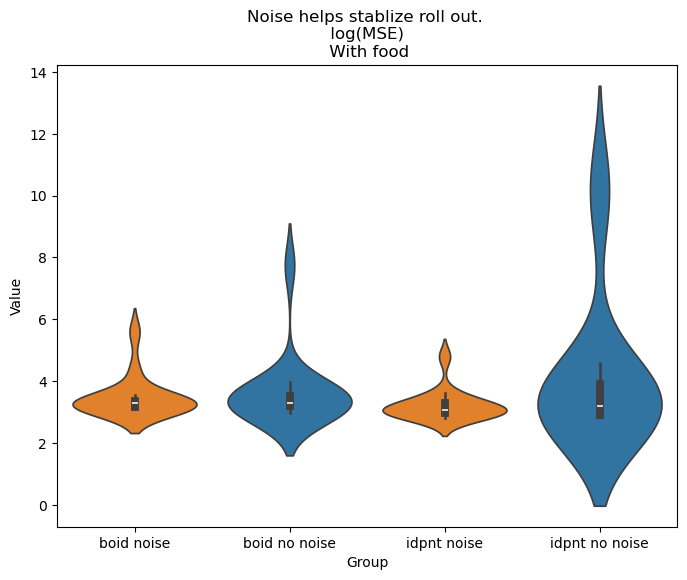

In [57]:
# Create a DataFrame with groups of different lengths
data = {
    'boid noise': mse_noise_boid,
    'boid no noise': mse_nonoise_boid,
    'idpnt noise': mse_noise_idpnt,
    'idpnt no noise': mse_nonoise_idpnt,
}

my_pal = {}
my_pal['boid noise'] = 'C1'
my_pal['boid no noise'] = 'C0'
my_pal['idpnt noise'] = 'C1'
my_pal['idpnt no noise'] = 'C0'

# Convert to long-form for seaborn
df_list = []
for group, values in data.items():
    df_list.append(pd.DataFrame({'Value': values, 'Group': group}))
df = pd.concat(df_list)

# Create the violin plot
plt.figure(figsize=(8, 6))
sns.violinplot(x='Group', y='Value', data=df, palette=my_pal)
plt.title('Noise helps stablize roll out. \n log(MSE) \n With food')
plt.show()

In [56]:
mse_by_frame_np = np.array(mse_by_frame_all)

In [48]:
rollout_results_names = list(rollout_results.keys())

# produce top model names:
indices = np.argsort(mse_by_frame_np[:,-1])[:20] #pick top 10
top_names = [model_names[rollout_results_names[ind]] for ind in indices]
print(top_names)

['foodidpnt_\nn0.005_h3_vr0.5_s2', 'foodidpnt_\nn0.005_h3_vr0.5_s4', 'foodidpnt_\nn0_h2_vr0.5_s2', 'foodidpnt_\nn0_h3_vr0.5_s4', 'foodidpnt_\nn0_h3_vr0.5_s0', 'foodidpnt_\nn0_h2_vr0.5_s1', 'foodidpnt_\nn0_h3_vr0.5_s3', 'foodbasic_\nn0_h3_vr0.5_s0', 'foodidpnt_\nn0.005_h3_vr0.5_s1', 'foodstrong_\nn0.005_h2_vr0.5_s0', 'foodstrong_\nn0_h1_vr0.5_s2', 'foodbasic_\nn0_h2_vr0.5_s4', 'foodidpnt_\nn0.005_h1_vr0.5_s0', 'foodidpnt_\nn0_h2_vr0.5_s0', 'foodidpnt_\nn0.005_h3_vr0.5_s0', 'foodidpnt_\nn0.005_h1_vr0.5_s2', 'foodidpnt_\nn0_h1_vr0.5_s3', 'foodidpnt_\nn0.005_h1_vr0.5_s3', 'foodstrong_\nn0.005_h3_vr0.5_s0', 'foodbasic_\nn0.005_h3_vr0.5_s2']


In [49]:
top_names

['foodidpnt_\nn0.005_h3_vr0.5_s2',
 'foodidpnt_\nn0.005_h3_vr0.5_s4',
 'foodidpnt_\nn0_h2_vr0.5_s2',
 'foodidpnt_\nn0_h3_vr0.5_s4',
 'foodidpnt_\nn0_h3_vr0.5_s0',
 'foodidpnt_\nn0_h2_vr0.5_s1',
 'foodidpnt_\nn0_h3_vr0.5_s3',
 'foodbasic_\nn0_h3_vr0.5_s0',
 'foodidpnt_\nn0.005_h3_vr0.5_s1',
 'foodstrong_\nn0.005_h2_vr0.5_s0',
 'foodstrong_\nn0_h1_vr0.5_s2',
 'foodbasic_\nn0_h2_vr0.5_s4',
 'foodidpnt_\nn0.005_h1_vr0.5_s0',
 'foodidpnt_\nn0_h2_vr0.5_s0',
 'foodidpnt_\nn0.005_h3_vr0.5_s0',
 'foodidpnt_\nn0.005_h1_vr0.5_s2',
 'foodidpnt_\nn0_h1_vr0.5_s3',
 'foodidpnt_\nn0.005_h1_vr0.5_s3',
 'foodstrong_\nn0.005_h3_vr0.5_s0',
 'foodbasic_\nn0.005_h3_vr0.5_s2']

In [58]:
#['foodbasic_\nn0_h3_vr0.5_s0','foodidpnt_\nn0.005_h3_vr0.5_s4','foodstrong_\nn0.005_h2_vr0.5_s0']

In [24]:
combinations_to_consider = [
    ('boid_food_basic', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2),
    ('boid_food_independent', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4),
    ('boid_food_strong', 'vpluspplus_a', 0, 3, 0.5, 0),
    ('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0)
]

In [54]:
model_names_subset = []
for model in rollout_results:
    model_combo = all_combinations[model]
    for c in combinations_to_consider:
        if np.sum([c[i] == model_combo[i] for i in range(len(c))]) == len(c):
            print(model_combo)
            model_names_subset.append(model)

('boid_food_basic', 'vpluspplus_a', 0, 3, 0.5, 0)
('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 0)
('boid_food_basic', 'vpluspplus_a', 0.005, 3, 0.5, 2)
('boid_food_independent', 'vpluspplus_a', 0, 3, 0.5, 0)
('boid_food_independent', 'vpluspplus_a', 0.005, 3, 0.5, 4)
('boid_food_strong', 'vpluspplus_a', 0.005, 3, 0.5, 0)


In [55]:
[mse_by_frame_all_dict[m] for m in model_names_subset]

[np.float32(16.398373),
 np.float32(20.20593),
 np.float32(19.373446),
 np.float32(15.85521),
 np.float32(15.078237),
 np.float32(17.670622)]